In [62]:
!pip install ipykernel

# to prepsocess our data
!pip install scikit-learn
# to do the nearual networs stuff
!pip install torch
# to see the metrics to evaluate our models created using pytorch
!pip install torchmetrics



In [63]:
!pip install pytorch-lightning

# all needed import statements from pytorch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, TensorDataset

from torchmetrics.functional import accuracy
from torchmetrics import F1Score

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

In [64]:
from google.colab import drive
drive.mount('/content/drive')
# /content/drive/MyDrive/MIT IDSS/insurance_CreateANN.csv
raw_data = pd.read_csv("/content/drive/MyDrive/MIT IDSS/insurance_CreateANN.csv") # raw data are the raw data for inurance
raw_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [65]:
# here is the complex NN present for ref using PyTorch

class SimpleNeuralNet(nn.Module):

  # init the layers
  def __init__(self, num_features):

    super().__init__()
    self.layer_1 = nn.Linear(num_features, 16)
    self.layer_2 = nn.Linear(16, 32)
    self.layer_3 = nn.Linear(32, 16)
    self.layer_out = nn.Linear(16, 1) # i/p o/p mapping between the layers

    self.relu = nn.ReLU()

  def forward(self, inputs): # forward propogation

    x = self.relu(self.layer_1(inputs))
    x = self.relu(self.layer_2(x))
    x = self.relu(self.layer_3(x))

    x = self.layer_out(x) # why not relu here? --> By now via the layers on neurons we are at a stage where we will def get an anwer as the maths is more or less done.
                          #Only positive results from RelU so might as well not add it.

    return (x)

  def predict(self, test_inputs):

    x = self.relu(self.layer_1(test_inputs))
    x = self.relu(self.layer_2(x))
    x = self.relu(self.layer_3(x))

    x = self.layer_out(x)

    return (x)


model = SimpleNeuralNet(num_features=8)
print(model)


SimpleNeuralNet(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [66]:
!pip install lightning # use this to remove boilerplate code or other nitty-gritty

In [67]:
import lightning.pytorch as pl

class InsuranceDataModule(pl.LightningDataModule): ## helps to do data loading and a bunch of data prep steps easily
  def __init__(self, batch_size: int = 8):
    super().__init__()
    self.batch_size = batch_size

  def prepare_data(self): # we are overrriding these from the base class
    self.insurance_data = pd.read_csv("/content/drive/MyDrive/MIT IDSS/insurance_CreateANN.csv")

  def setup(self, stage = None):
    x = self.insurance_data.drop(columns = ["charges"])
    y = self.insurance_data["charges"]

    if stage == "fit" or stage is None:
      x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 123)

      categorical_features = ["sex", "smoker", "region"]

      categorical_transformer = OneHotEncoder(
          handle_unknown = "ignore", drop = "first", sparse_output = False
      )

      preproc = ColumnTransformer(
          transformers = [("cat_tr", categorical_transformer, categorical_features)],
          remainder = "passthrough"
      )

      x_train = preproc.fit_transform(x_train)
      x_val = preproc.transform(x_val)

      y_train = y_train.to_numpy()
      y_val = y_val.to_numpy()

      # Std scaling features
      stdscaler = StandardScaler()
      x_train = stdscaler.fit_transform(x_train)
      x_val = stdscaler.transform(x_val)

      # min max scaling targets
      min_max_scaler = MinMaxScaler()
      y_train = min_max_scaler.fit_transform(y_train.reshape(-1, 1))
      y_val = min_max_scaler.transform(y_val.reshape(-1, 1))

      # Convert to tensors
      self.train_inputs = torch.from_numpy(x_train).float()
      self.train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()
      self.val_inputs = torch.from_numpy(x_val).float()
      self.val_targets = torch.from_numpy(y_val.reshape(-1, 1)).float()

  def train_dataloader(self):
    train_dataset = TensorDataset(
        self.train_inputs, self.train_targets
    )
    train_loader = DataLoader(
        dataset = train_dataset,
        batch_size = self.batch_size,
        shuffle = True,
        num_workers = 2
    )
    return train_loader

  def val_dataloader(self):
    validation_dataset = TensorDataset(
        self.val_inputs, self.val_targets
    )
    validation_loader = DataLoader(
        dataset = validation_dataset,
        batch_size = self.batch_size,
        num_workers = 2
    )
    return validation_loader

In [68]:
insurance_dm = InsuranceDataModule()
insurance_dm.prepare_data()
insurance_dm.setup()

In [69]:
train_dl = insurance_dm.train_dataloader()

next(iter(train_dl)) # view the loop

[tensor([[ 0.9888,  2.0000, -0.5809,  1.6095, -0.5478,  1.7632,  0.5375, -0.8865],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.9835,  1.2321,  1.5709],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  1.0544,  0.2085, -0.0674],
         [ 0.9888, -0.5000, -0.5809, -0.6213,  1.8254, -0.8594, -0.0574,  1.5709],
         [-1.0113, -0.5000, -0.5809,  1.6095, -0.5478,  0.8418,  0.5741, -0.8865],
         [-1.0113, -0.5000,  1.7213, -0.6213, -0.5478,  0.2747,  0.6538, -0.0674],
         [-1.0113, -0.5000, -0.5809, -0.6213,  1.8254, -0.7885, -0.8052, -0.8865],
         [ 0.9888, -0.5000,  1.7213, -0.6213, -0.5478,  0.5582, -0.1355,  1.5709]]),
 tensor([[0.7445],
         [0.3146],
         [0.1595],
         [0.0511],
         [0.1328],
         [0.1075],
         [0.0332],
         [0.1383]])]

In [70]:
###################################

# another method of creating NN

class LitRegressionModule(pl.LightningModule): # encapsulates everything NN creation related and not just data loader like we have seen before

  def __init__(self, num_features, learning_rate = 0.01): # LR to be used by optimizers
    super().__init__()
    self.layer_1 = nn.Linear(num_features, 16)
    self.layer_2 = nn.Linear(16, 32)
    self.layer_3 = nn.Linear(32, 16)
    self.layer_out = nn.Linear(16, 1) # i/p o/p mapping between the layers

    self.relu = nn.ReLU()
    self.save_hyperparameters() # all the i/p args will be saved into the self.hparams object which can be referenced anytime

  def configure_optimizers(self):
    return optim.SGD(self.parameters(), lr = self.hparams.learning_rate)

  def forward(self, inputs):
    x = self.relu(self.layer_1(inputs))
    x = self.relu(self.layer_2(x))
    x = self.relu(self.layer_3(x))

    x = self.layer_out(x)
    return (x)

  def training_step(self, batch, batch_idx):
    x, y = batch

    output = self.forward(x)
    loss_fn = nn.MSELoss(reduction = "mean")
    loss = loss_fn(output, y)

    self.log("train_loss", loss, prog_bar = True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch

    output = self.forward(x)
    loss_fn = nn.MSELoss(reduction = "mean")
    loss = loss_fn(output, y)

    self.log(f"val_loss", loss, on_epoch = True , prog_bar = True)

  def predict_step(self, batch, batch_idx, dataloader_idx = 0):
    x, y = batch
    return self(x)

In [71]:
model = LitRegressionModule(num_features=8)
print(model)

LitRegressionModule(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [72]:
# train your model which is easy here

from pytorch_lightning.loggers import CSVLogger

insurance_dm = InsuranceDataModule()

logger = CSVLogger("logs", name = "pytorch_lightning_training")

trainer = pl.Trainer(max_epochs = 50, logger = logger) # Trainer class takes care of all the training, loss_fn etc. related function

trainer.fit(model, datamodule = insurance_dm) # needs a lighting model with those functions overriden. Note the output

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type   | Params
-------------------------------------
0 | layer_1   | Linear | 144   
1 | layer_2   | Linear | 544   
2 | layer_3   | Linear | 528   
3 | layer_out | Linear | 17    
4 | relu      | ReLU   | 0     
-------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type   | Params
-------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [73]:
# predictions, lets use the validation data set which has been set aside to see predictions

preds = trainer.predict(model = model, dataloaders = insurance_dm.val_dataloader())

preds

Predicting: |          | 0/? [00:00<?, ?it/s]

[tensor([[0.2286],
         [0.0919],
         [0.4389],
         [0.0691],
         [0.2121],
         [0.1522],
         [0.1036],
         [0.0482]]),
 tensor([[0.0344],
         [0.1701],
         [0.1328],
         [0.2048],
         [0.2148],
         [0.4389],
         [0.1615],
         [0.4453]]),
 tensor([[0.2429],
         [0.0637],
         [0.5896],
         [0.7023],
         [0.4964],
         [0.8344],
         [0.0899],
         [0.1508]]),
 tensor([[0.0465],
         [0.1489],
         [0.2181],
         [0.0553],
         [0.2094],
         [0.0096],
         [0.0754],
         [0.1874]]),
 tensor([[0.0589],
         [0.0407],
         [0.0665],
         [0.1691],
         [0.3532],
         [0.0137],
         [0.1144],
         [0.1459]]),
 tensor([[0.1199],
         [0.1177],
         [0.0164],
         [0.4456],
         [0.1192],
         [0.0443],
         [0.1806],
         [0.1542]]),
 tensor([[0.1740],
         [0.1438],
         [0.1270],
         [0.1676],


In [74]:
y_pred_stacked = torch.cat(preds)

y_pred_stacked[:10]

tensor([[0.2286],
        [0.0919],
        [0.4389],
        [0.0691],
        [0.2121],
        [0.1522],
        [0.1036],
        [0.0482],
        [0.0344],
        [0.1701]])

In [75]:
labels = []

for data, label in insurance_dm.val_dataloader():
  labels.extend(label)

y_true = torch.stack(labels)
y_true[:10]

tensor([[0.1412],
        [0.0577],
        [0.5485],
        [0.0651],
        [0.1793],
        [0.1559],
        [0.0603],
        [0.0593],
        [0.0090],
        [0.1340]])

In [76]:
from torchmetrics.regression import R2Score
from torchmetrics.regression import MeanSquaredError

MSE = MeanSquaredError()
r2score = R2Score()

print("MSE: ", round(MSE(y_pred_stacked, y_true).item(), 3))
print("R Squared: ", round(r2score(y_pred_stacked, y_true).item(), 3))

# Note how to check the metrics at trainer and CSVLogger, etc.

MSE:  0.006
R Squared:  0.863


In [77]:
## Lets build and train a classification Model

import warnings

warnings.filterwarnings("ignore","is_categorical_dtype")
warnings.filterwarnings("ignore","use_inf_as_na") # ignore some warnings that may appear (project sake)

from google.colab import drive
drive.mount('/content/drive')
churn_data = pd.read_csv("/content/drive/MyDrive/MIT IDSS/Churn_Modelling_CreateANN.csv") # raw data are the raw data for inurance
churn_data.head()
# churn_data.columns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [78]:
# rid cols not needed

churn_data.info()
churn_data.dropna(inplace = True) # records with missing vals
churn_data.drop_duplicates()
churn_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


(9998, 14)

In [79]:
churn_data["Exited"].value_counts() # we see a skewed data set, less amount of cases for Exited is 1, thus less to learn from

0    7960
1    2038
Name: Exited, dtype: int64

<Axes: xlabel='Exited', ylabel='count'>

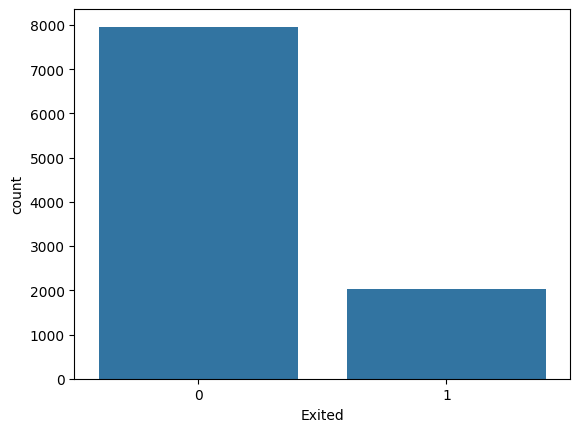

In [80]:
sns.countplot(data = churn_data, x = "Exited")

In [81]:
# Data Module

class ChurnDataModule(pl.LightningDataModule):
  def __init__(self, batch_size: int = 8):
    super().__init__()
    self.batch_size = batch_size

  def prepare_data(self):
    self.churn_data = churn_data

  def setup(self, stage = None):
    x = self.churn_data.drop(
        columns = ["Exited", "RowNumber", "CustomerId", "Surname"]
    )
    y = self.churn_data["Exited"]

    if stage == "fit" or stage is None: # why?
      x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 123)

      # One Hot Encoding
      cat_features = ['Geography', 'Gender']
      cat_transformer = OneHotEncoder(
          handle_unknown = "ignore", drop = "first", sparse_output = False
       )
      preproc = ColumnTransformer(
          transformers = [('cat_tr', cat_transformer, cat_features)],
          remainder = 'passthrough'
      )

      x_train = preproc.fit_transform(x_train)
      x_val = preproc.transform(x_val)

      y_train, y_val = np.array(y_train), np.array(y_val)

      # Scaling inputs

      scaler = StandardScaler()
      inputs_train_array = scaler.fit_transform(x_train)
      inputs_val_array = scaler.transform(x_val)

      # Input arrays and labels are coverted into tensors
      self.train_inputs = torch.from_numpy(x_train).float()
      self.train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()
      self.val_inputs = torch.from_numpy(x_val).float()
      self.val_targets = torch.from_numpy(y_val.reshape(-1, 1)).float()

  def train_dataloader(self):
      train_dataset = TensorDataset(
          self.train_inputs, self.train_targets
      )
      train_loader = DataLoader(
          dataset = train_dataset,
          batch_size = self.batch_size,
          shuffle = True,
          num_workers = 2
      )
      return train_loader

  def val_dataloader(self):
      validation_dataset = TensorDataset(
          self.val_inputs, self.val_targets
      )
      validation_loader = DataLoader(
          dataset = validation_dataset,
          batch_size = self.batch_size,
          num_workers = 2
      )
      return validation_loader

In [82]:
churn_dm = ChurnDataModule()
churn_dm.prepare_data()
churn_dm.setup()

In [83]:
train_dl = churn_dm.train_dataloader()

batch_train = next(iter(train_dl)) # view the loop to see the batch per entry

batch_train

[tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 7.2900e+02, 3.2000e+01, 6.0000e+00,
          9.3694e+04, 1.0000e+00, 1.0000e+00, 1.0000e+00, 7.9919e+04],
         [0.0000e+00, 1.0000e+00, 1.0000e+00, 7.1900e+02, 4.4000e+01, 4.0000e+00,
          0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 8.4973e+04],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 5.6900e+02, 3.7000e+01, 9.0000e+00,
          1.7876e+05, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.9993e+05],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7000e+02, 6.1000e+01, 6.0000e+00,
          1.4211e+05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 4.5214e+04],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 8.2600e+02, 2.9000e+01, 4.0000e+00,
          1.2994e+05, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.9020e+05],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 7.7800e+02, 3.7000e+01, 3.0000e+00,
          1.4180e+05, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.7942e+05],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 6.4800e+02, 2.7000e+01, 7.0000e+00,


In [84]:
# pick the first one and see how many columns --> no of features --> no of inuputs to neurons
num_feat = batch_train[0].shape[1]
num_feat

11

In [85]:
val_dl = churn_dm.val_dataloader()

batch_val = next(iter(val_dl)) # view the loop to see the batch per entry

batch_val

[tensor([[0.0000e+00, 0.0000e+00, 1.0000e+00, 7.5600e+02, 6.0000e+01, 2.0000e+00,
          0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.6651e+05],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 7.7800e+02, 4.7000e+01, 6.0000e+00,
          1.2730e+05, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.2469e+05],
         [1.0000e+00, 0.0000e+00, 0.0000e+00, 5.8500e+02, 3.9000e+01, 7.0000e+00,
          1.6561e+05, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.3185e+05],
         [1.0000e+00, 0.0000e+00, 0.0000e+00, 6.5900e+02, 3.2000e+01, 3.0000e+00,
          1.5092e+05, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.7465e+05],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.4100e+02, 5.3000e+01, 0.0000e+00,
          1.2384e+05, 2.0000e+00, 0.0000e+00, 1.0000e+00, 1.6011e+05],
         [0.0000e+00, 1.0000e+00, 1.0000e+00, 7.4800e+02, 3.6000e+01, 4.0000e+00,
          1.4157e+05, 1.0000e+00, 1.0000e+00, 0.0000e+00, 8.2158e+04],
         [0.0000e+00, 1.0000e+00, 0.0000e+00, 6.8400e+02, 4.1000e+01, 7.0000e+00,


In [86]:
# lets train using a Lightning Module object

class LitBinaryClassfnModule(pl.LightningModule):
  def __init__(self, num_features, learning_rate = 0.001): # LR to be used by optimizers
    super().__init__()
    self.layer_1 = nn.Linear(num_features, 16)
    self.act1 = nn.ReLU()
    self.layer_2 = nn.Linear(16, 8)
    self.act2 = nn.ReLU()
    self.layer_3 = nn.Linear(8, 4)
    self.act3 = nn.ReLU()
    self.output = nn.Linear(4, 1) # i/p o/p mapping between the layers

    self.save_hyperparameters() # all the i/p args will be saved into the self.hparams object which can be referenced anytime

  def forward(self, x): # forward propogation

      x = self.act1(self.layer_1(x))
      x = self.act2(self.layer_2(x))
      x = self.act3(self.layer_3(x))

      x = self.output(x) # why not relu here? --> By now via the layers on neurons we are at a stage where we will def get an anwer as the maths is more or less done.
                            #Only positive results from RelU so might as well not add it.
      return (x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(logits, y)

    self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(logits, y)

    preds = torch.round(torch.sigmoid(logits))
    acc = accuracy(preds, y, task = "binary")

    f1_score = F1Score(task = "binary")
    f1 = f1_score(preds, y)

    self.log(f"val_loss", loss, on_epoch = True , prog_bar = True)
    self.log(f"val_acc", acc, on_epoch = True , prog_bar = True)
    self.log(f"val_f1", f1, on_epoch = True , prog_bar = True)

  def predict_step(self, batch, batch_idx, dataloader_idx = 0):
    x, y = batch
    return self(x)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr = self.hparams.learning_rate)


In [87]:
cln_model = LitBinaryClassfnModule(num_features = num_feat)

cln_model

LitBinaryClassfnModule(
  (layer_1): Linear(in_features=11, out_features=16, bias=True)
  (act1): ReLU()
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (act2): ReLU()
  (layer_3): Linear(in_features=8, out_features=4, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
from pytorch_lightning.loggers import CSVLogger # log data into a CSV file

churn_dm = ChurnDataModule()

logger = CSVLogger("logs", name = "pytorch_lightning_classification")

trainer = pl.Trainer(max_epochs = 20, logger = logger)

trainer.fit(cln_model, datamodule = churn_dm)

# take the metric data generated from csv into a df and then analyse --> plot graph, do further processing, etc.
# TODO

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 192   
1 | act1    | ReLU   | 0     
2 | layer_2 | Linear | 136   
3 | act2    | ReLU   | 0     
4 | layer_3 | Linear | 36    
5 | act3    | ReLU   | 0     
6 | output  | Linear | 5     
-----------------------------------
369       Trainable params
0         Non-trainable params
369       Total params
0.001     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]